In [89]:
states = ('Healthy', 'Fever')
 
observations = ('normal', 'cold', 'dizzy')
 
start_probability = {'Healthy': 0.6, 'Fever': 0.4}
 
transition_probability = {
   'Healthy' : {'Healthy': 0.7, 'Fever': 0.3},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6},
   }
 
emission_probability = {
   'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
   }
# Helps visualize the steps of Viterbi.
def print_dptable(V):
    print "    ",
    for i in range(len(V)): print "%7d" % i,
    print

    for y in V[0].keys():
        print "%.5s: " % y,
        for t in range(len(V)):
            print "%.7s" % ("%f" % V[t][y]),
        print

def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}

    # Initialize base cases (t == 0)
    for y in states:
        V[0][y] = start_p[y] * emit_p[y][obs[0]]
        path[y] = [y]

    # Run Viterbi for t > 0
    for t in range(1,len(obs)):
        V.append({})
        newpath = {}

        for y in states:
            (prob, state) = max([(V[t-1][y0] * trans_p[y0][y] * emit_p[y][obs[t]], y0) for y0 in states])
            V[t][y] = prob
            newpath[y] = path[state] + [y]

        # Don't need to remember the old paths
        path = newpath

    print_dptable(V)
    (prob, state) = max([(V[len(obs) - 1][y], y) for y in states])
    return (prob, path[state])

def example():
    return viterbi(observations,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability)
print example()

           0       1       2
Healt:  0.30000 0.08400 0.00588
Fever:  0.04000 0.02700 0.01512
(0.01512, ['Healthy', 'Healthy', 'Fever'])


In [5]:
import os
import jieba
import sys
import numpy as np
import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

import pandas as pd
import pickle
import sklearn
import codecs
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras import layers as L
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter, defaultdict


pd.set_option('display.width', 1000)

print(keras.__version__)
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)

# utf-8s设定 中文
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

#进行配置，每个GPU使用60%上限现存
os.environ["CUDA_VISIBLE_DEVICES"]="0" # 使用编号为1，2号的GPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3 # 每个GPU现存上届控制在30%以内
session = tf.Session(config=config)
KTF.set_session(session )


BATCH_SIZE=64 #64速度大大加强

2.1.6
0.22.0
1.14.5
0.19.1


In [6]:
import locale, sys
print(sys.getdefaultencoding())    #系统默认编码
print(sys.getfilesystemencoding()) #文件系统编码
print(locale.getdefaultlocale())   #系统当前编码
print(sys.stdin.encoding)          #终端输入编码
print(sys.stdout.encoding)         #终端输出编码


utf-8
ANSI_X3.4-1968
(None, None)
None
UTF-8


## 1. 数据

### 1.1 加载数据和分词

In [7]:

def process(inpath, outpath):
    with open(inpath, 'r') as fin, open(outpath, 'w') as fout:
        for line in fin:
            lineno, sen1, sen2 = line.strip().split('\t')
            words1= [ w for w in jieba.cut(sen1) if w.strip() ]
            words2= [ w for w in jieba.cut(sen2) if w.strip() ]
            union = words1 + words2
            same_num = 0
            for w in union:
                if w in words1 and w in words2:
                    same_num += 1
            if same_num * 2 >= len(union):
                fout.write(lineno + '\t1\n')
            else:
                fout.write(lineno + '\t0\n')


def load_data(filepath):
    data = []
    with open(filepath, 'r') as f:
        i = 0 
        for line in f:
            lineno, sent1, sent2, tag = line.strip().split('\t')
            data.append((lineno, sent1, sent2, tag))
    return data      


def split_sentence(sentence):
    return [w for w in jieba.cut(sentence) if w.strip() ]

def split_sentence(sentence):
    return [w for w in sentence.decode('utf-8') if w.strip() ]


def segmentation(data, split=split_sentence, userwords_filepath='words.txt', stupwords_filepath='stopwords.txt'):
    jieba.load_userdict(userwords_filepath) 
    new_data = []
    for  (lineno, sen1, sen2, tag) in data:
        words1 = split(sen1)
        words2 = split(sen2)
        new_data.append((lineno, words1, words2, tag))
    return new_data


# 创建停用词list  
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r').readlines()]  
    return stopwords  


# 对句子进行分词  
def remove_stopwords(data, ):  
    sentence_seged = jieba.cut(sentence.strip())  
    stopwords = stopwordslist('./test/stopwords.txt')  # 这里加载停用词的路径  
    outstr = ''  
    for word in sentence_seged:  
        if word not in stopwords:  
            if word != '\t':  
                outstr += word  
                outstr += " "  
    return outstr  


def print_unicode(text):
    print(repr(text).decode('unicode_escape'))
    
def print_utf8(text):
    print(repr(text).decode('string_escape'))    


data_raw = load_data('./data/atec_nlp_sim_train.csv') + load_data('./data/atec_nlp_sim_train_add.csv')
print(len(data_raw))

102477


In [8]:
for  (lineno, sen1, sen2, tag) in data_raw[0:2]:
    print_utf8((sen1, sen2))
    for word in sen1.decode('utf-8'):
        print_utf8(word)

('怎么更改花呗手机号码', '我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号')
u'\u600e'
u'\u4e48'
u'\u66f4'
u'\u6539'
u'\u82b1'
u'\u5457'
u'\u624b'
u'\u673a'
u'\u53f7'
u'\u7801'
('也开不了花呗，就这样了？完事了', '真的嘛？就是花呗付款')
u'\u4e5f'
u'\u5f00'
u'\u4e0d'
u'\u4e86'
u'\u82b1'
u'\u5457'
u'\uff0c'
u'\u5c31'
u'\u8fd9'
u'\u6837'
u'\u4e86'
u'\uff1f'
u'\u5b8c'
u'\u4e8b'
u'\u4e86'


In [9]:

data = segmentation(data_raw)   

In [10]:
#去除字符乱码
print_unicode(data[0])   
data[0]=('1', data[0][1], data[0][2], data[0][3])

print_utf8(data_raw[3])
print_unicode(data[3][1])

('ï»¿1', [u'怎', u'么', u'更', u'改', u'花', u'呗', u'手', u'机', u'号', u'码'], [u'我', u'的', u'花', u'呗', u'是', u'以', u'前', u'的', u'手', u'机', u'号', u'码', u'，', u'怎', u'么', u'更', u'改', u'成', u'现', u'在', u'的', u'支', u'付', u'宝', u'的', u'号', u'码', u'手', u'机', u'号'], '1')
('4', '如何得知关闭借呗', '想永久关闭借呗', '0')
[u'如', u'何', u'得', u'知', u'关', u'闭', u'借', u'呗']


In [11]:
word_counts = Counter()
for (_, sent1, sent2, _) in data:   
    word_counts.update(sent1)
    word_counts.update(sent2)
print(len(word_counts), len(data)) 
print_unicode(word_counts.most_common(100))

low_freq_words = [word for word, count in word_counts.items() if count==3] 
print('three-occur word: ',len(low_freq_words))  #8960  total:13419
print_unicode(low_freq_words[0:10])

low_freq_words = [word for word, count in word_counts.items() if count==2] 
print('two-occur word: ',len(low_freq_words))  #1690  total:13419
print_unicode(low_freq_words[0:10])

low_freq_words = [word for word, count in word_counts.items() if count==1] 
print('one-occur word: ', len(low_freq_words))  #6423  total:13419
print_unicode(low_freq_words[0:10])

one_freq_words = low_freq_words

#分词的一些问题：  ('我用', 2051)

(2171, 102477)
[(u'呗', 211063), (u'花', 151025), (u'么', 83328), (u'还', 80050), (u'借', 69825), (u'我', 67036), (u'款', 62302), (u'的', 61108), (u'了', 56689), (u'用', 52685), (u'*', 50301), (u'不', 49940), (u'，', 46908), (u'怎', 43828), (u'吗', 42240), (u'什', 36860), (u'是', 34797), (u'期', 34456), (u'额', 33816), (u'能', 33219), (u'可', 33022), (u'以', 32472), (u'有', 30674), (u'付', 29243), (u'为', 29144), (u'蚂', 28459), (u'蚁', 28453), (u'分', 24341), (u'度', 22906), (u'开', 21435), (u'没', 21279), (u'支', 20091), (u'钱', 19894), (u'一', 19394), (u'通', 19357), (u'个', 19138), (u'在', 16865), (u'宝', 16033), (u'提', 14865), (u'到', 14833), (u'时', 14146), (u'号', 13690), (u'月', 13378), (u'多', 12928), (u'账', 12853), (u'收', 12378), (u'要', 11408), (u'费', 11183), (u'退', 10992), (u'后', 10709), (u'前', 10689), (u'使', 10529), (u'卡', 10075), (u'会', 9729), (u'手', 9311), (u'信', 9119), (u'里', 8620), (u'码', 8459), (u'现', 8355), (u'扣', 8209), (u'示', 8051), (u'天', 7917), (u'少', 7899), (u'这', 7772), (u'商', 7726), (u'行', 7519), (u'关'

从上面结果可以看出，低频词特别多，其中只出现一次的词高达6423，几乎占了所有词汇的一半以上。

**数据分成train, validation**

In [73]:
X_all = [(sent1, sent2)  for (_, sent1, sent2, _) in data] 
y_all = np.array([tag  for (_, _, _, tag) in data]).astype(int)

X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
print(len(X_all), len(y_all))
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print_unicode(X_train[0])


(102477, 102477)
(71733, 71733)
(30744, 30744)
([u'我', u'的', u'来', u'分', u'期', u'评', u'估', u'和', u'支', u'付', u'宝', u'评', u'估', u'两', u'者', u'是', u'一', u'样', u'的', u'评', u'估', u'么'], [u'我', u'用', u'支', u'付', u'宝', u'买', u'东', u'西', u'也', u'蛮', u'多', u'的'])


('max length =', 112)


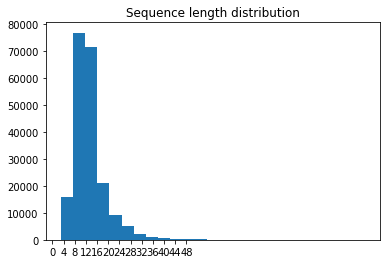

In [74]:
sents_all = [sent for (sent, _) in X_all] + [sent for (_, sent) in X_all]    
MAX_LENGTH = max(map(len, sents_all))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.xticks(np.linspace(0,48,13,endpoint=True))
plt.hist(list(map(len,sents_all)),bins=25);


上图可以看出，大部分的句子长度在8个长度左右。

In [75]:
word_counts = Counter()
for (sent1, sent2) in X_train:   
    word_counts.update(sent1)
    word_counts.update(sent2)
    
low_freq_words = [word for word, count in word_counts.items() if count==1] 
print('one-occur word: ', len(low_freq_words))  #6423  total:13419
print_unicode(low_freq_words[0:10])

one_freq_words = low_freq_words   

('one-occur word: ', 467)
[u'則', u'抗', u'脖', u'潜', u'孒', u'衰', u'泳', u'闹', u'驼', u'戗']


In [76]:
print(y_all.shape)
y_bin = np.bincount(y_all)
ii = np.nonzero(y_bin)[0]
print(np.vstack((ii,y_bin[ii])).T)

(102477,)
[[    0 83792]
 [    1 18685]]


从上面的结果来看数据的倾斜非常厉害。

### 1.2 矩阵化

In [77]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"


def generate_vocabulary(X_train, min_occur_count=5):    
    words = [ word for (sent, _)  in X_train for word in sent  ] + [ word for (_, sent)  in X_train for word in sent  ] 
    vocab = Counter(words)
    vocab = [PAD, UNK, START, END] + [word for word, count in vocab.items() if count>=min_occur_count ] 
    return {token: index for index, token in enumerate(sorted(vocab))}

def tokens_to_indices(X, vocab):    
    matrix_1 = [[vocab.get(word, vocab[UNK]) for word in sent] for (sent, _)  in X] 
    matrix_2 = [[vocab.get(word, vocab[UNK]) for word in sent] for (_, sent)  in X]     
    return matrix_1, matrix_2

def to_matrix(X_indexed, pad=0, max_len=None, dtype='int32'):
    if max_len  is None:
        max_len = max(map(len, X_indexed[0]) + map(len, X_indexed[1]))
    else:
        max_len = min(max_len, max(map(len, X_indexed[0]) + map(len, X_indexed[1])))    
        
    max_len = max_len or max(map(len, X_indexed[0]) + map(len, X_indexed[1]))
    matrix1 = np.empty([len(X_indexed[0]),max_len],dtype)
    matrix2 = np.empty([len(X_indexed[1]),max_len],dtype)
    matrix1.fill(pad)
    matrix2.fill(pad)
    
    for i in range(len(X_indexed[0])):
        line_ix = X_indexed[0][i][:max_len]
        matrix1[i,:len(line_ix)] = line_ix
        
    for i in range(len(X_indexed[1])):
        line_ix = X_indexed[1][i][:max_len]
        matrix2[i,:len(line_ix)] = line_ix    
    return matrix1, matrix2    




In [78]:
vocab = generate_vocabulary(X_train, min_occur_count=1)
vocab_inverse = {idx: w for w, idx in vocab.items()}

In [79]:
print(len(vocab))
print_unicode(list(vocab)[0:5])
# print(vocab[PAD], vocab[UNK], vocab[START], vocab[END], vocab[u"花呗"], vocab[u"借呗"], vocab[u"开通"], vocab[u"支付宝"])

2025
[u'怀', u'挂', u'耀', u'谈', u'随']


In [80]:
# index化。
X_train_indexed = tokens_to_indices(X_train, vocab)
X_val_indexed = tokens_to_indices(X_val, vocab)
X_sample_indexed = tokens_to_indices(X_train[0:3], vocab)

In [81]:

for i in range(len(X_sample_indexed[0])):
    print('-----------------------------------------')
    sent1 = [vocab_inverse[index] for index in X_sample_indexed[0][i]]
    sent2 = [vocab_inverse[index] for index in X_sample_indexed[1][i]]
    print_unicode(sent1)
    print_unicode(sent2)
    print_unicode(X_train[i][0])
    print_unicode(X_train[i][1])
  
    
#检查一下，是否一些低频词被替换成#UNK#。
def filter_by_word(X, word):
    indices = [i for i,(sent1, sent2) in enumerate(X) if word in sent1 or word in sent2]
    return indices

def show_words(X_indexed, indice):
    sent1 = [ vocab_inverse[i] for i in X_indexed[0][indice]] 
    sent2 = [ vocab_inverse[i] for i in X_indexed[1][indice]] 
    print_unicode((sent1, sent2))

print('=========================================')  
print_unicode(one_freq_words[0:10])  # [u'只得', u'有发', u'填完', u'过日子', u'二立', u'选泽', u'银子', u'吸', u'号通', u'禁言']
# indice = filter_by_word(X_train, u'过日子')[0]
# print_unicode(X_train[indice])
# show_words(X_train_indexed, indice)
# print(X_train_indexed[0][indice], X_train_indexed[1][indice])

print('=========================================') 


X_train_seq = to_matrix(X_train_indexed, max_len=25, pad=vocab[PAD])
X_val_seq = to_matrix(X_val_indexed, max_len=25, pad=vocab[PAD])
X_sample_seq = to_matrix(X_sample_indexed, max_len=25, pad=vocab[PAD])


for i in range(len(X_sample_indexed[0])):
    print('-----------------------------------------')
    sent1 = X_sample_indexed[0][i]
    sent2 = X_sample_indexed[1][i]
    sent11 = X_sample_seq[0][i]
    sent21 = X_sample_seq[1][i]   
    print_unicode(sent1)
    print_unicode(sent2)
    print_unicode(sent11)
    print_unicode(sent21)

-----------------------------------------
[u'我', u'的', u'来', u'分', u'期', u'评', u'估', u'和', u'支', u'付', u'宝', u'评', u'估', u'两', u'者', u'是', u'一', u'样', u'的', u'评', u'估', u'么']
[u'我', u'用', u'支', u'付', u'宝', u'买', u'东', u'西', u'也', u'蛮', u'多', u'的']
[u'我', u'的', u'来', u'分', u'期', u'评', u'估', u'和', u'支', u'付', u'宝', u'评', u'估', u'两', u'者', u'是', u'一', u'样', u'的', u'评', u'估', u'么']
[u'我', u'用', u'支', u'付', u'宝', u'买', u'东', u'西', u'也', u'蛮', u'多', u'的']
-----------------------------------------
[u'身', u'份', u'证', u'过', u'期', u'借', u'呗', u'是', u'不', u'是', u'额', u'度', u'没', u'办', u'法', u'用']
[u'我', u'的', u'身', u'份', u'证', u'过', u'期', u'了', u'为', u'什', u'么', u'不', u'能', u'办', u'蚂', u'蚁', u'借', u'呗']
[u'身', u'份', u'证', u'过', u'期', u'借', u'呗', u'是', u'不', u'是', u'额', u'度', u'没', u'办', u'法', u'用']
[u'我', u'的', u'身', u'份', u'证', u'过', u'期', u'了', u'为', u'什', u'么', u'不', u'能', u'办', u'蚂', u'蚁', u'借', u'呗']
-----------------------------------------
[u'借', u'呗', u'提', u'前', u'还', u'款', u'后', u'没', u

In [82]:
# def to_matrix_dssm(X_indexed, vocab_len, ngram=2, pad=0, max_len=None, dtype='int32'):
#     if max_len  is None:
#         max_len = max(map(len, X_indexed[0]) + map(len, X_indexed[1]))
#     else:
#         max_len = min(max_len, max(map(len, X_indexed[0]) + map(len, X_indexed[1])))    
        
#     max_len = max_len or max(map(len, X_indexed[0]) + map(len, X_indexed[1]))
#     max_depth = vocab_len*ngram
#     matrix1 = np.zeros([len(X_indexed[0]),max_len, max_depth],dtype)
#     matrix2 = np.zeros([len(X_indexed[1]),max_len, max_depth],dtype)
    
#     for i in range(len(X_indexed[0])):
#         line_ix = X_indexed[0][i][:max_len]
#         one_gram_matrix = np.zeros([len(line_ix)+ngram-1, vocab_len])
#         one_gram_matrix[0:len(line_ix),] = np.eye(vocab_len)[line_ix]
#         for j in range(len(line_ix)):
#             matrix1[i, j, :] = one_gram_matrix[j:(j+ngram),].flatten()
        
#     for i in range(len(X_indexed[1])):
#         line_ix = X_indexed[1][i][:max_len]
#         one_gram_matrix = np.zeros([len(line_ix)+ngram-1, vocab_len])
#         one_gram_matrix[0:len(line_ix),] = np.eye(vocab_len)[line_ix]
#         for j in range(len(line_ix)):
#             matrix2[i, j, :] = one_gram_matrix[j:(j+ngram),].flatten()

#     print(matrix1)
#     print(matrix2)
#     return (matrix1, matrix2) 


In [83]:
# X_train_dssm = to_matrix_dssm(X_train_indexed, vocab_len=len(vocab), ngram=2, max_len=25)
# X_val_dssm =   to_matrix_dssm(X_val_indexed,   vocab_len=len(vocab), ngram=2, max_len=25)

# X_sample_indexed_dssm= ([[1, 2, 3, 2], [0, 4]], [[2,3], [0, 3, 2]])
# X_sample_dssm = to_matrix_dssm(X_sample_indexed_dssm, vocab_len=5, ngram=2, max_len=5)


# # def to_matrix_dssm(X_indexed, vocab_len, ngram=2, pad=0, max_len=None, dtype='int32'):
# for i in range(len(X_sample_indexed_dssm[0])):
#     print('-----------------------------------------')
#     sent1 = X_sample_indexed_dssm[0][i]
#     sent2 = X_sample_indexed_dssm[1][i]
#     sent11 = X_sample_dssm[0][i]
#     sent21 =  X_sample_dssm[1][i]  
#     print_unicode(sent1)
#     print_unicode(sent2)
#     print_unicode(sent11)
#     print_unicode(sent21)

### 1.2 BOW(bag-of-words)

#### 1.2.1 TF-IDF

In [26]:
def tfidf_vectorize(X_train):
    corpus = ["".join(sent) for (sent, _) in X_train] + ["".join(sent) for (_, sent) in X_train]
#     vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
#     vectorizer = TfidfVectorizer(ngram_range=(1,2), analyzer='char')
    vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer='char')
    vectorizer.fit(corpus) 
    return vectorizer

def tfidf_to_matrix(X, vectorizer):
    corpus_list1 = ["".join(sent) for (sent, _) in X]
    corpus_list2 = ["".join(sent) for (_, sent) in X]
    matrix_1 = vectorizer.transform(corpus_list1)
    matrix_2 = vectorizer.transform(corpus_list2)
    return matrix_1, matrix_2

vectorizer= tfidf_vectorize(X_train)  
X_train_tfidf = tfidf_to_matrix(X_train, vectorizer)
X_val_tfidf = tfidf_to_matrix(X_val, vectorizer)


In [27]:
import math

def save_object(obj, filename):
    with open(filename, 'wb') as output: 
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):        
    with open(filename, 'rb') as input:
        obj = pickle.load(input)        
    return obj
        
save_object(X_train, 'X_train.pkl')

X_train_load  = load_object('X_train.pkl')
print_unicode(X_train[0])
print_unicode(X_train_load[0])

# file_X_train = open('X_train.obj', 'w')
# pickle.dump(X_train, file_X_train)

([u'我', u'的', u'来', u'分', u'期', u'评', u'估', u'和', u'支', u'付', u'宝', u'评', u'估', u'两', u'者', u'是', u'一', u'样', u'的', u'评', u'估', u'么'], [u'我', u'用', u'支', u'付', u'宝', u'买', u'东', u'西', u'也', u'蛮', u'多', u'的'])
([u'我', u'的', u'来', u'分', u'期', u'评', u'估', u'和', u'支', u'付', u'宝', u'评', u'估', u'两', u'者', u'是', u'一', u'样', u'的', u'评', u'估', u'么'], [u'我', u'用', u'支', u'付', u'宝', u'买', u'东', u'西', u'也', u'蛮', u'多', u'的'])


In [28]:
print(X_train_tfidf[0].shape, X_train_tfidf[1].shape)
print(X_val_tfidf[0].shape, X_val_tfidf[1].shape)

((71733, 2021), (71733, 2021))
((30744, 2021), (30744, 2021))


In [29]:
#查看tfidf后的结果
def show_sentence(X, y, X_tfidf, words, items=range(10), y_pred=None, a_pred=None):
    for i in items:
        print('------------------------row %d------------------------' % (i))
        print("sent1: {} \nsent2: {} ".format(''.join(X[i][0]), ''.join(X[i][1])) )
        if y_pred is None:
            print("y = {}".format(y[i]))
        else:
            print("y = {}, y_pred = {}, a_pred= {}".format(y[i], y_pred[i], a_pred[i]))
        sent1_tfidf, sent2_tfidf = [], []
        for j in range(len(words)):
            if X_tfidf[0][i,j] >= 1e-10: sent1_tfidf.append(words[j] + "=" + '{:.8f}'.format(X_tfidf[0][i,j]))
            if X_tfidf[1][i,j] >= 1e-10: sent2_tfidf.append(words[j] + "=" + '{:.8f}'.format(X_tfidf[1][i,j]))
        print('tfidf1: {}'.format(', '.join(sent1_tfidf)))
        print('tfidf2: {}'.format(', '.join(sent2_tfidf)))

words = vectorizer.get_feature_names()
show_sentence(X_train, y_train,  X_train_tfidf, words, items=np.arange(0, 6000, 400))

------------------------row 0------------------------
sent1: 我的来分期评估和支付宝评估两者是一样的评估么 
sent2: 我用支付宝买东西也蛮多的 
y = 0
tfidf1: 一=0.10378576, 两=0.16997967, 么=0.05810486, 付=0.09276879, 估=0.61879771, 分=0.09734784, 和=0.14428454, 宝=0.10969795, 我=0.06849599, 支=0.10355410, 是=0.08933426, 期=0.08704420, 来=0.15649276, 样=0.14027876, 的=0.14178021, 者=0.23020450, 评=0.61227283
tfidf2: 东=0.30985178, 也=0.31565385, 买=0.26733672, 付=0.17686618, 多=0.21959855, 宝=0.20914208, 我=0.13058943, 支=0.19742866, 用=0.14059786, 的=0.13515388, 蛮=0.64686831, 西=0.31166555
------------------------row 400------------------------
sent1: 花呗有没有像信用卡那样最后还款日后三天还都不算逾期，也没费用 
sent2: 我花呗逾期了，现在工资还没发，能不能宽限几天 
y = 0
tfidf1: 三=0.26629830, 不=0.10145845, 也=0.22628726, 信=0.16976104, 像=0.32835394, 卡=0.16656231, 后=0.32784250, 呗=0.04177731, 天=0.17927967, 日=0.20034204, 最=0.19483287, 有=0.24726129, 期=0.11896844, 样=0.19172724, 款=0.09496800, 没=0.27160251, 用=0.20158477, 算=0.22285566, 花=0.05551629, 费=0.16343738, 还=0.17804385, 逾=0.18204135, 那=0.22435108, 都=0.20

In [30]:
def get_indices(y_index, batch_size):
    indices = np.random.permutation(np.arange(len(y_index)))
    return list(y_index[indices[0:batch_size]] )

#尝试随机的得到label比例是1：1的batch数据， 不知道这样是覅偶可以有做帮助数据倾斜的问题。
#看来这招还挺有用，val f1很快从0.25提高到0.36
#random_sent 无论是true, false, 对结果影响不是很大。
def generate_batches_tfidf(X, y, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True):  
    while True:
        y_index_1 = np.array([i for i,label in enumerate(y) if label==1])
        y_index_0 = np.array([i for i,label in enumerate(y) if label==0])

        y_index_1_batch_size = int(batch_size*positive_ratio)
        y_index_0_batch_size = batch_size - y_index_1_batch_size
        
        for start in range(0,len(y)-1,batch_size):
            index = np.random.permutation(np.arange(2)) if random_sent else np.arange(2)
            batch_indices = get_indices(y_index_1, y_index_1_batch_size) + get_indices(y_index_0, y_index_0_batch_size)
            yield [X[index[0]][batch_indices].toarray(), X[index[1]][batch_indices].toarray()], y[batch_indices]  


## 2. 模型

下面是自己写的一个求f1_score, precison, recall, accuracy的类，应该可以用sklearn里面的相同功能替换。

In [31]:
class Predictor(object):
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        A = self.model.predict(X)
        return self.predict_(A)

    def predict_(self, A):
        return A
    

class ClassificationPredictor(Predictor):

    def __init__(self, model):
        Predictor.__init__(self, model)

    def predict_(self, A):
        if A.shape[1]== 1:
            return np.int32(A > 0.5).flatten()
        else: 
            return  np.argmax(A, axis=-1)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return self.accuracy_(y_pred, y)

    def accuracy_(self, y_pred, y):
        return np.mean(y_pred == y)

    def evaluate(self, X, y, title=""):
        y_pred = self.predict(X)
        accuracy = self.accuracy_(y_pred, y)

        metrics = []

        tp = np.sum((y_pred==1) * (y==1))*1.0
        fn = np.sum((y_pred==0) * (y==1))*1.0
        fp = np.sum((y_pred==1) * (y==0))*1.0
        tn = np.sum((y_pred==0) * (y==0))*1.0

        recall = tp/(tp+fn) if tp>0 else 0
        precision = tp/(tp+fp) if tp>0 else 0
        specificity = tn/(tn+fp) if tn>0 else 0
        f1 = 2*recall*precision/(recall+precision) if recall+precision>0 else 0

        metrics.append([accuracy, recall, precision, specificity, f1, tp, fn, fp, tn])

        metrics = pd.DataFrame(metrics, index=[title],
                               columns=['accuracy', 'recall', 'precision', 'specificity', 'f1',  'tp', 'fn', 'fp', 'tn'])
        return metrics

    def print_metrics(self, train_X, train_y, dev_X=None, dev_y=None, test_X=None, test_y=None):
        metrics = []
        if train_X is not None:
            metrics_ = self.evaluate(train_X, train_y)
            metrics_.index=["train"]
            metrics.append(metrics_)
        if dev_X is not None:
            metrics_ = self.evaluate(dev_X, dev_y)
            metrics_.index = ["dev"]
            metrics.append(metrics_)
        if test_X is not None:
            metrics_ = self.evaluate(test_X, test_y)
            metrics_.index = ["test"]
            metrics.append(metrics_)
        print(pd.concat(metrics))

    def print_accuracy(self, X, y, title="train"):
        print("{} accuracy: {}".format(title, self.accuracy(X, y)))

    def print_accuracy_train_test(self, train_X, train_y, dev_X=None, dev_y=None, test_X=None, test_y=None):
        if train_X is not None:
            self.print_accuracy(train_X, train_y, "train")
        if dev_X is not None:
            self.print_accuracy(dev_X, dev_y, "dev")
        if test_X is not None:
            self.print_accuracy(test_X, test_y, "test")
            
def accuracy1(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precision1 = precision(y_true, y_pred)
    recall1 = recall(y_true, y_pred)
    return 2*((precision1*recall1)/(precision1+recall1+K.epsilon()))

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score            

### 2.1 BOW + NN



In [32]:
def get_model():
    K.clear_session()

    input_shape = X_train_tfidf[0].shape[1]

    model_sent1 = Sequential()
    model_sent1.add(L.Dense(512, input_shape=(input_shape,)))
    model_sent1.add(L.Activation('relu')) 
    model_sent1.add(L.Dropout(0.1))
    model_sent1.add(L.Dense(128))
    model_sent1.add(L.Activation('relu')) 
    model_sent1.add(L.Dropout(0.1))

    model_sent2 = Sequential()
    model_sent2.add(L.Dense(512, input_shape=(input_shape,)))
    model_sent2.add(L.Activation('relu')) 
    model_sent2.add(L.Dropout(0.1))
    model_sent2.add(L.Dense(128))
    model_sent2.add(L.Activation('relu')) 
    model_sent2.add(L.Dropout(0.1))

    input1 = L.Input(shape=(input_shape, ))
    input2 = L.Input(shape=(input_shape, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(64)(X)
    X = L.Activation('elu')(X)
    X = L.Dropout(0.1)(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)
    X = L.Dropout(0.1)(X)
    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

In [33]:
def compute_test_accuracy(model):
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(X_val_tfidf, verbose=1)

    #compute accurary excluding padding
    numerator = np.sum(predicted_tags == y_val)
    denominator = len(y_val)
    return float(numerator)/denominator


class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        acc = compute_test_accuracy(self.model)
        print("\nValidation accuracy: %.5f\n" % acc)
        sys.stdout.flush()

In [179]:
print(y_train.shape)
print(X_train_tfidf[1].shape)
print(X_train_tfidf[0].shape, X_train_tfidf[1].shape)
model = get_model()
model.summary()

model.fit([X_train_tfidf[0], X_train_tfidf[1]], y_train, validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val], epochs=5, batch_size=BATCH_SIZE)

(71733,)
(71733, 1955)
((71733, 1955), (71733, 1955))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1955)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1955)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1067136     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1067136     input_2[0][0]                    
_______________________________________________________

In [385]:
model.fit([X_train_tfidf[0], X_train_tfidf[1]], y_train, validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val], epochs=5, batch_size=BATCH_SIZE)

Train on 71733 samples, validate on 30744 samples
Epoch 1/10
71733/71733 [==============================] - 22s 300us/step - loss: 0.4334 - acc: 0.8296 - recall: 0.1380 - precision: 0.5964 - f1: 0.2129 - val_loss: 0.4632 - val_acc: 0.8165 - val_recall: 0.0630 - val_precision: 0.3530 - val_f1: 0.1019
Epoch 2/10
71733/71733 [==============================] - 22s 300us/step - loss: 0.4192 - acc: 0.8365 - recall: 0.1895 - precision: 0.6879 - f1: 0.2833 - val_loss: 0.4750 - val_acc: 0.8095 - val_recall: 0.0961 - val_precision: 0.3547 - val_f1: 0.1447
Epoch 3/10
71733/71733 [==============================] - 21s 300us/step - loss: 0.4044 - acc: 0.8441 - recall: 0.2385 - precision: 0.7198 - f1: 0.3431 - val_loss: 0.4770 - val_acc: 0.8104 - val_recall: 0.0862 - val_precision: 0.3533 - val_f1: 0.1322
Epoch 4/10
71733/71733 [==============================] - 22s 300us/step - loss: 0.3901 - acc: 0.8500 - recall: 0.2782 - precision: 0.7410 - f1: 0.3880 - val_loss: 0.4841 - val_acc: 0.8058 - val_re

In [106]:
            
print(y_train.shape)
print(X_train_tfidf[1].shape)
print(X_train_tfidf[0].shape, X_train_tfidf[1].shape)

model = get_model()
model.summary()

model.fit_generator(
    generate_batches_tfidf(X_train_tfidf, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val]
) 



(71733,)
(71733, 2021)
((71733, 2021), (71733, 2021))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2021)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2021)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          1100928     input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1100928     input_2[0][0]                    
_______________________________________________________

In [107]:
model.fit_generator(
    generate_batches_tfidf(X_train_tfidf, y_train), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_tfidf[0], X_val_tfidf[1]], y_val]
) 

Epoch 1/5
1120/1120 [==============================] - 12s 11ms/step - loss: 0.4699 - acc: 0.7883 - recall: 0.8039 - precision: 0.7828 - f1: 0.7909 - val_loss: 0.5434 - val_acc: 0.7417 - val_recall: 0.5109 - val_precision: 0.3490 - val_f1: 0.4059
Epoch 2/5
1120/1120 [==============================] - 12s 11ms/step - loss: 0.4336 - acc: 0.8111 - recall: 0.8305 - precision: 0.8032 - f1: 0.8143 - val_loss: 0.6132 - val_acc: 0.6997 - val_recall: 0.5878 - val_precision: 0.3179 - val_f1: 0.4049
Epoch 3/5
1120/1120 [==============================] - 12s 11ms/step - loss: 0.4096 - acc: 0.8237 - recall: 0.8429 - precision: 0.8147 - f1: 0.8267 - val_loss: 0.6154 - val_acc: 0.7104 - val_recall: 0.5646 - val_precision: 0.3234 - val_f1: 0.4037
Epoch 4/5
1120/1120 [==============================] - 12s 11ms/step - loss: 0.3807 - acc: 0.8388 - recall: 0.8586 - precision: 0.8294 - f1: 0.8418 - val_loss: 0.5920 - val_acc: 0.7274 - val_recall: 0.5302 - val_precision: 0.3358 - val_f1: 0.4027
Epoch 5/5
11

In [108]:
# # Test score...
# y_val_pred = model.predict([X_val_tfidf[0], X_val_tfidf[1]])
# # val_class = np.int(val_predictions>=0.5)
# print(val_predictions.shape)

predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_tfidf[0], X_val_tfidf[1]], y_val, title='val'))
print(predictor.evaluate([X_train_tfidf[0], X_train_tfidf[1]], y_train, title='train'))

print(predictor.evaluate([X_val_tfidf[1], X_val_tfidf[0]], y_val, title='val'))
print(predictor.evaluate([X_train_tfidf[1], X_train_tfidf[0]], y_train, title='train'))


     accuracy   recall  precision  specificity        f1      tp      fn      fp       tn
val  0.711001  0.55877   0.324069     0.744388  0.410222  3090.0  2440.0  6445.0  18769.0
       accuracy   recall  precision  specificity        f1       tp      fn       fp       tn
train  0.838066  0.90802   0.534428     0.822357  0.672844  11945.0  1210.0  10406.0  48172.0
     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val   0.71048  0.549186   0.321546     0.745855  0.405609  3037.0  2493.0  6408.0  18806.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.836365  0.907944    0.53153     0.820291  0.670522  11944.0  1211.0  10527.0  48051.0


In [185]:
show_sentence(X_val, y_val,  X_val_tfidf, words, items=np.arange(0, len(X_val), 2200), 
              y_pred=predictor.predict([X_val_tfidf[0], X_val_tfidf[1]]), a_pred=model.predict([X_val_tfidf[0], X_val_tfidf[1]])  )

------------------------row 0------------------------
sent1: 我的花呗还款到底是怎么回事 
sent2: 花呗还款***是什么意思 
y = 0, y_pred = 0, a_pred= [0.28875333]
tfidf1: 么=0.14807314, 事=0.44262431, 到=0.28308761, 呗=0.07789550, 回=0.38072136, 底=0.57279022, 怎=0.19585989, 我=0.17455366, 是=0.22765745, 款=0.17707171, 的=0.18065477, 花=0.10351239, 还=0.16598502
tfidf2: 么=0.19450228, 什=0.27536231, 呗=0.10232005, 思=0.58232405, 意=0.57203474, 是=0.29904069, 款=0.23259351, 花=0.13596927, 还=0.21803052
------------------------row 2200------------------------
sent1: 我不差花呗钱怎么会扣钱了 
sent2: 花呗都扣钱啦 
y = 0, y_pred = 0, a_pred= [0.21557876]
tfidf1: 不=0.18674019, 么=0.14616855, 了=0.18500349, 会=0.31458552, 呗=0.07689357, 差=0.59332336, 怎=0.19334065, 我=0.17230847, 扣=0.32585325, 花=0.10218097, 钱=0.51858960
tfidf2: 呗=0.09663953, 啦=0.69354256, 扣=0.40953108, 花=0.12842064, 都=0.46824538, 钱=0.32588069
------------------------row 4400------------------------
sent1: 我还清了花呗还扣我的钱 
sent2: 我换了花呗为什么有扣我的钱 
y = 0, y_pred = 0, a_pred= [0.07963774]
tfidf1: 了=0.23648

In [79]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [27]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])

# predictor = ClassificationPredictor(loaded_model)
# print(predictor.evaluate([X_val_seq[0], X_val_seq[1]], y_val, title='val'))
# print(predictor.evaluate([X_train_seq[0], X_train_seq[1]], y_train, title='train'))
# model = loaded_model

Loaded model from disk


### 2.2 Word Embedding + NN

In [36]:
def get_indices(y_index, batch_size):
    indices = np.random.permutation(np.arange(len(y_index)))
    return list(y_index[indices[0:batch_size]] )

#尝试随机的得到label比例是1：1的batch数据， 不知道这样是覅偶可以有做帮助数据倾斜的问题。
#看来这招还挺有用，val f1很快从0.25提高到0.36
def generate_batches_seq(X, y, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True):  
    while True:
        y_index_1 = np.array([i for i,label in enumerate(y) if label==1])
        y_index_0 = np.array([i for i,label in enumerate(y) if label==0])

        y_index_1_batch_size = int(batch_size*positive_ratio)
        y_index_0_batch_size = batch_size - y_index_1_batch_size
    
        
        for start in range(0,len(y)-1,batch_size):
            index = np.random.permutation(np.arange(2)) if random_sent else np.arange(2)
            batch_indices = get_indices(y_index_1, y_index_1_batch_size) + get_indices(y_index_0, y_index_0_batch_size)
            yield [X[index[0]][batch_indices], X[index[1]][batch_indices]], y[batch_indices]  

In [37]:
from keras.layers.merge import concatenate, dot

def get_model():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 128))
    model_sent1.add(L.SimpleRNN(128,return_sequences=False))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 128))
    model_sent2.add(L.SimpleRNN(128,return_sequences=False))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(64)(X)
    X = L.Activation('elu')(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)

    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

def get_model_gru():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 128))
    model_sent1.add(L.GRU(128, return_sequences=False))
#     model_sent1.add(L.CuDNNGRU(128,return_sequences=False))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 128))
    model_sent2.add(L.GRU(128, return_sequences=False))
#     model_sent2.add(L.CuDNNGRU(128,return_sequences=False))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(64)(X)
    X = L.Activation('elu')(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)

    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

def get_model_gru_cosine():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 64))
    model_sent1.add(L.GRU(64, return_sequences=False))                    
#     model_sent1.add(L.CuDNNGRU(64,return_sequences=False))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 64))
    model_sent2.add(L.GRU(64, return_sequences=False))               
#     model_sent2.add(L.CuDNNGRU(64,return_sequences=False))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 
    

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    predictions = dot([encoder1, encoder2], axes = 1, normalize = True) 

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

def get_model_lstm():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 128))
    model_sent1.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 128))
    model_sent2.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    X = L.concatenate([encoder1, encoder2])
    X = L.Dense(128)(X)
    X = L.Activation('elu')(X)
    X = L.Dense(32)(X)
    X = L.Activation('elu')(X)

    predictions = L.Dense(1, activation='sigmoid')(X)

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

# def get_model_gru_cosine():
#     K.clear_session()

#     model_sent1 = Sequential()
#     model_sent1.add(L.InputLayer([None], dtype='int32'))
#     model_sent1.add(L.Embedding(len(vocab), 128))
#     model_sent1.add(L.CuDNNGRU(128,return_sequences=False))
#     model_sent1.add(L.Dense(64))
#     model_sent1.add(L.Activation('elu')) 

#     model_sent2 = Sequential()
#     model_sent2.add(L.InputLayer([None], dtype='int32'))
#     model_sent2.add(L.Embedding(len(vocab), 128))
#     model_sent2.add(L.CuDNNGRU(128,return_sequences=False))
#     model_sent2.add(L.Dense(64))
#     model_sent2.add(L.Activation('elu')) 
    

#     input1 = L.Input(shape=(None, ))
#     input2 = L.Input(shape=(None, ))

#     encoder1 = model_sent1(input1)
#     encoder2 = model_sent2(input2)

#     predictions = dot([encoder1, encoder2], axes = 1, normalize = True) 

#     model = Model(inputs=[input1, input2], outputs=predictions)
#     model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
#     return model



def get_model_lstm_cosine(embedding_size=64):
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), embedding_size))
    model_sent1.add(L.CuDNNLSTM(embedding_size,return_sequences=False))

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), embedding_size))
    model_sent2.add(L.CuDNNLSTM(embedding_size,return_sequences=False))
 

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    predictions = dot([encoder1, encoder2], axes = 1, normalize = True) 

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

In [38]:
            
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 


(71733,)
2025
(71733, 25)
((71733, 25), (71733, 25))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          292096      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          292096      input_4[0][0]                    
________________________________________________________

In [146]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

Epoch 1/1
1120/1120 [==============================] - 11s 10ms/step - loss: 0.4152 - acc: 0.8283 - recall: 0.8550 - precision: 0.8162 - f1: 0.8333 - val_loss: 0.6307 - val_acc: 0.7388 - val_recall: 0.6126 - val_precision: 0.3661 - val_f1: 0.4502


In [28]:
predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_seq[0], X_val_seq[1]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[0], X_train_seq[1]], y_train, title='train'))

print(predictor.evaluate([X_val_seq[1], X_val_seq[0]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[1], X_train_seq[0]], y_train, title='train'))

     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val  0.721311  0.669982   0.354613     0.732569  0.463763  3705.0  1825.0  6743.0  18471.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train   0.78512  0.848651   0.454061     0.770853  0.591596  11164.0  1991.0  13423.0  45155.0
     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val  0.717376  0.660036   0.348982     0.729952  0.456564  3650.0  1880.0  6809.0  18405.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.783252  0.846978   0.451514     0.768941  0.589025  11142.0  2013.0  13535.0  45043.0


In [49]:
            
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model_gru()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 


(71733,)
2025
(71733, 25)
((71733, 25), (71733, 25))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          358272      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          358272      input_4[0][0]                    
________________________________________________________

In [33]:
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model_gru_cosine()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=15,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

(71733,)
2025
(71733, 25)
((71733, 25), (71733, 25))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          203712      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          203712      input_4[0][0]                    
________________________________________________________

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [84]:
def get_model_gru_cosine_dropout():
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 64))
    model_sent1.add(L.GRU(64,  dropout=0.3, recurrent_dropout=0.3, return_sequences=False))                    

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 64))
    model_sent2.add(L.GRU(64,  dropout=0.3, recurrent_dropout=0.3, return_sequences=False))               

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    predictions = dot([encoder1, encoder2], axes = 1, normalize = True) 

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

model = get_model_gru_cosine_dropout()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           154368      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64)           154368      input_4[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [ ]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=20,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

Epoch 1/20
1120/1120 [==============================] - 115s 103ms/step - loss: 0.6412 - acc: 0.6350 - recall: 0.6063 - precision: 0.6461 - f1: 0.6225 - val_loss: 0.6764 - val_acc: 0.6267 - val_recall: 0.6459 - val_precision: 0.2726 - val_f1: 0.3772
Epoch 2/20
1120/1120 [==============================] - 114s 102ms/step - loss: 0.6341 - acc: 0.6442 - recall: 0.6271 - precision: 0.6516 - f1: 0.6363 - val_loss: 0.6774 - val_acc: 0.5993 - val_recall: 0.7062 - val_precision: 0.2672 - val_f1: 0.3818
Epoch 3/20
1120/1120 [==============================] - 113s 101ms/step - loss: 0.6293 - acc: 0.6537 - recall: 0.6588 - precision: 0.6549 - f1: 0.6542 - val_loss: 0.6727 - val_acc: 0.5979 - val_recall: 0.7228 - val_precision: 0.2693 - val_f1: 0.3866
Epoch 4/20
1120/1120 [==============================] - 113s 101ms/step - loss: 0.6202 - acc: 0.6631 - recall: 0.6806 - precision: 0.6602 - f1: 0.6677 - val_loss: 0.6563 - val_acc: 0.6228 - val_recall: 0.7045 - val_precision: 0.2802 - val_f1: 0.3948


In [ ]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE,     
    epochs=20,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

Epoch 1/20
1120/1120 [==============================] - 113s 101ms/step - loss: 0.5494 - acc: 0.7382 - recall: 0.7723 - precision: 0.7260 - f1: 0.7463 - val_loss: 0.6438 - val_acc: 0.6551 - val_recall: 0.7784 - val_precision: 0.3142 - val_f1: 0.4414
Epoch 2/20
1120/1120 [==============================] - 113s 101ms/step - loss: 0.5482 - acc: 0.7386 - recall: 0.7717 - precision: 0.7268 - f1: 0.7465 - val_loss: 0.6316 - val_acc: 0.6603 - val_recall: 0.7744 - val_precision: 0.3177 - val_f1: 0.4441
Epoch 3/20
1120/1120 [==============================] - 113s 101ms/step - loss: 0.5452 - acc: 0.7417 - recall: 0.7792 - precision: 0.7280 - f1: 0.7507 - val_loss: 0.6336 - val_acc: 0.6592 - val_recall: 0.7860 - val_precision: 0.3188 - val_f1: 0.4469
Epoch 4/20
1120/1120 [==============================] - 113s 101ms/step - loss: 0.5410 - acc: 0.7422 - recall: 0.7779 - precision: 0.7291 - f1: 0.7506 - val_loss: 0.6436 - val_acc: 0.6503 - val_recall: 0.7884 - val_precision: 0.3124 - val_f1: 0.4412


In [72]:
predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_seq[0], X_val_seq[1]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[0], X_train_seq[1]], y_train, title='train'))

print(predictor.evaluate([X_val_seq[1], X_val_seq[0]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[1], X_train_seq[0]], y_train, title='train'))

     accuracy    recall  precision  specificity        f1      tp     fn      fp       tn
val  0.715262  0.753879   0.364365     0.706648  0.491283  2818.0  920.0  4916.0  11842.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train   0.77263  0.895297   0.439374     0.745279  0.589463  13382.0  1565.0  17075.0  49959.0
     accuracy    recall  precision  specificity       f1      tp     fn      fp       tn
val  0.717359  0.752006   0.366159     0.709631  0.49251  2811.0  927.0  4866.0  11892.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.772325  0.897371   0.439137     0.744443  0.589699  13413.0  1534.0  17131.0  49903.0


In [47]:
def get_model_gru_cnn(kernel_size=3):
    K.clear_session()

    model_sent1 = Sequential()
    model_sent1.add(L.InputLayer([None], dtype='int32'))
    model_sent1.add(L.Embedding(len(vocab), 64))
    model_sent1.add(L.Convolution1D(64, kernel_size=kernel_size, padding = "same", activation = "elu"))
    model_sent1.add(L.GRU(64,  dropout=0.1, recurrent_dropout=0.1, return_sequences=False))        
   

    model_sent2 = Sequential()
    model_sent2.add(L.InputLayer([None], dtype='int32'))
    model_sent2.add(L.Embedding(len(vocab), 64))
    model_sent2.add(L.Convolution1D(64, kernel_size=kernel_size, padding = "same", activation = "elu"))
    model_sent2.add(L.GRU(64,  dropout=0.1, recurrent_dropout=0.1, return_sequences=False))        
  

    input1 = L.Input(shape=(None, ))
    input2 = L.Input(shape=(None, ))

    encoder1 = model_sent1(input1)
    encoder2 = model_sent2(input2)

    predictions = dot([encoder1, encoder2], axes = 1, normalize = True) 

    model = Model(inputs=[input1, input2], outputs=predictions)
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

In [48]:
BATCH_SIZE1  = 64
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model_gru_cnn(kernel_size=3)
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE1, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE1, 
    epochs=5,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

(71733,)
2025
(71733, 25)
((71733, 25), (71733, 25))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           166720      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64)           166720      input_4[0][0]                    
________________________________________________________

In [53]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, batch_size=BATCH_SIZE, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=10,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

Epoch 1/10
1120/1120 [==============================] - 116s 104ms/step - loss: 0.4112 - acc: 0.8257 - recall: 0.8585 - precision: 0.8129 - f1: 0.8334 - val_loss: 0.6643 - val_acc: 0.7090 - val_recall: 0.6801 - val_precision: 0.3494 - val_f1: 0.4536
Epoch 2/10
1120/1120 [==============================] - 117s 104ms/step - loss: 0.4096 - acc: 0.8274 - recall: 0.8592 - precision: 0.8154 - f1: 0.8351 - val_loss: 0.6676 - val_acc: 0.7166 - val_recall: 0.6687 - val_precision: 0.3567 - val_f1: 0.4572
Epoch 3/10
1120/1120 [==============================] - 116s 103ms/step - loss: 0.4101 - acc: 0.8265 - recall: 0.8600 - precision: 0.8133 - f1: 0.8344 - val_loss: 0.6637 - val_acc: 0.7163 - val_recall: 0.6580 - val_precision: 0.3535 - val_f1: 0.4516
Epoch 4/10
1120/1120 [==============================] - 114s 102ms/step - loss: 0.4070 - acc: 0.8276 - recall: 0.8600 - precision: 0.8150 - f1: 0.8352 - val_loss: 0.6632 - val_acc: 0.7180 - val_recall: 0.6635 - val_precision: 0.3557 - val_f1: 0.4548


In [399]:
# def get_model_lstm():
#     K.clear_session()

#     model_sent1 = Sequential(a)
#     model_sent1.add(L.InputLayer([None], dtype='int32'))
#     model_sent1.add(L.Embedding(len(vocab), 128))
#     model_sent1.add(L.CuDNNLSTM(128,return_sequences=False))
# #     model_sent1.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
# #     model_sent1.add(L.Dense(64))
# #     model_sent1.add(L.Activation('elu')) 

#     model_sent2 = Sequential()
#     model_sent2.add(L.InputLayer([None], dtype='int32'))
#     model_sent2.add(L.Embedding(len(vocab), 128))
#     model_sent2.add(L.CuDNNLSTM(128,return_sequences=False))
# #     model_sent2.add(L.Bidirectional(L.CuDNNLSTM(128,return_sequences=False)))
# #     model_sent2.add(L.Dense(64))
# #     model_sent2.add(L.Activation('elu')) 

#     input1 = L.Input(shape=(None, ))
#     input2 = L.Input(shape=(None, ))

#     encoder1 = model_sent1(input1)
#     encoder2 = model_sent2(input2)

#     X = L.concatenate([encoder1, encoder2])
    
#     X = L.Conv2D(filters=16, kernel_size=5, padding="same")(X)
#     X = L.Flatten()(X)
#     X = L.Dense(128)(X)
#     X = L.Activation('elu')(X)
#     X = L.Dense(32)(X)
#     X = L.Activation('elu')(X)

#     predictions = L.Dense(1, activation='sigmoid')(X)

#     model = Model(inputs=[input1, input2], outputs=predictions)
#     model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
#     return model

In [136]:
print(y_train.shape)
print(len(vocab))
print(X_train_seq[1].shape)
print(X_train_seq[0].shape, X_train_seq[1].shape)

model = get_model_lstm_cosine()
model.summary()

model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=10,
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 


(71733,)
2025
(71733, 25)
((71733, 25), (71733, 25))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          391296      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          391296      input_4[0][0]                    
________________________________________________________

In [137]:
model.fit_generator(
    generate_batches_seq(X_train_seq, y_train, positive_ratio=0.5, random_sent=True), 
    steps_per_epoch=len(y_train) // BATCH_SIZE, 
    epochs=5,    
    validation_data=[[X_val_seq[0], X_val_seq[1]], y_val]
) 

Epoch 1/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.5594 - acc: 0.7220 - recall: 0.7588 - precision: 0.7099 - f1: 0.7313 - val_loss: 0.6135 - val_acc: 0.6841 - val_recall: 0.6634 - val_precision: 0.3179 - val_f1: 0.4223
Epoch 2/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.5590 - acc: 0.7325 - recall: 0.7783 - precision: 0.7160 - f1: 0.7437 - val_loss: 0.6182 - val_acc: 0.6862 - val_recall: 0.6818 - val_precision: 0.3240 - val_f1: 0.4316
Epoch 3/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.5431 - acc: 0.7439 - recall: 0.7896 - precision: 0.7266 - f1: 0.7547 - val_loss: 0.6495 - val_acc: 0.6660 - val_recall: 0.7032 - val_precision: 0.3114 - val_f1: 0.4243
Epoch 4/5
1120/1120 [==============================] - 13s 11ms/step - loss: 0.5339 - acc: 0.7496 - recall: 0.7911 - precision: 0.7336 - f1: 0.7592 - val_loss: 0.6422 - val_acc: 0.6973 - val_recall: 0.6574 - val_precision: 0.3297 - val_f1: 0.4308
Epoch 5/5
11

In [113]:
predictor = ClassificationPredictor(model)
print(predictor.evaluate([X_val_seq[0], X_val_seq[1]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[0], X_train_seq[1]], y_train, title='train'))

print(predictor.evaluate([X_val_seq[1], X_val_seq[0]], y_val, title='val'))
print(predictor.evaluate([X_train_seq[1], X_train_seq[0]], y_train, title='train'))

     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val   0.67431  0.663291   0.310348     0.676727  0.422849  3668.0  1862.0  8151.0  17063.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.716295  0.773622   0.369401     0.703421  0.500037  10177.0  2978.0  17373.0  41205.0
     accuracy    recall  precision  specificity        f1      tp      fn      fp       tn
val  0.673757  0.661483    0.30958      0.67645  0.421769  3658.0  1872.0  8158.0  17056.0
       accuracy    recall  precision  specificity        f1       tp      fn       fp       tn
train  0.714288  0.771342   0.367193     0.701475  0.497536  10147.0  3008.0  17487.0  41091.0


### 2.3 DSSM

In [ ]:
def get_model():
    K.clear_session()


#     model_sent1 = Sequential()
#     model_sent1.add(L.InputLayer([None], dtype='int32'))
#     model_sent1.add(L.Embedding(len(vocab), 128))
#     model_sent1.add(L.SimpleRNN(128,return_sequences=False))
# #     model_sent1.add(L.Dense(64))
# #     model_sent1.add(L.Activation('elu')) 

#     model_sent2 = Sequential()
#     model_sent2.add(L.InputLayer([None], dtype='int32'))
#     model_sent2.add(L.Embedding(len(vocab), 128))
#     model_sent2.add(L.SimpleRNN(128,return_sequences=False))
# #     model_sent2.add(L.Dense(64))
# #     model_sent2.add(L.Activation('elu')) 

#     input1 = L.Input(shape=(None, ))
#     input2 = L.Input(shape=(None, ))

#     encoder1 = model_sent1(input1)
#     encoder2 = model_sent2(input2)

#     X = L.concatenate([encoder1, encoder2])
#     X = L.Dense(64)(X)
#     X = L.Activation('elu')(X)
#     X = L.Dense(32)(X)
#     X = L.Activation('elu')(X)

#     predictions = L.Dense(1, activation='sigmoid')(X)

#     model = Model(inputs=[input1, input2], outputs=predictions)
#     model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy', recall, precision, f1])
    
    return model

## 思路
- 分词效果分析
- 错误分类分析
    - 同音词分析
- Data Augmentation   
    - 去除一个或若干个词。
- 外部训练好的word embedding向量。 
- 把所有汉字变成拼音，这样可以有晓解决谐音字的问题。  07-07

## 总结

- BOW
    - fit： 经过15 epochs，f1在0.25左右  
    val_loss: 0.5505 - val_acc: 0.7726 - val_recall: 0.2186 - val_precision: 0.3074 - val_f1: 0.2459
    - fit_generator + generate_batches_tfidf：
        - 由于数据倾斜比较厉害，所以在获得batch的时候，正例:反例=1:1，这种情况下性能快速提高。 f1提高到0.37。  下面是5 epochs 的结果。如果再增加epochs，则过拟合更加严重。     
    
            val_loss: 0.6349 - val_acc: 0.6664 - val_recall: 0.5774 - val_precision: 0.2874 - val_f1: 0.3761      
      
        - 另外一个体会是，以前会用某一个阈值（一般0.5，如果数据）来计算y_pred, 但现在发现可能用generate_batches_tfidf里，设定positive的比例，更加简单，效果也更好。尝试了positive_ratio=[0.6,0.5.0.4,0.3,0.2], 发现当positive_ratio=[0.6,0.5,0.4]的时候,性能接近。当positive_ratio=0.3，f1马上下降到0.3，当positive_ratio=0.2，性能非常差。这也进一步证明数据倾斜的问题。    
    
        - 随机化两个句子的顺序。
        
            当调用 generate_batches_tfidf(X_train_tfidf, y_train, positive_ratio=0.5, random_sent=False) 产生traiing数据， 结果如下：  

![ali_nlp_random_sent_false.ipynb](../../../image/ali_nlp_random_sent_false.png)

            而调用 generate_batches_tfidf(X_train_tfidf, y_train, positive_ratio=0.5, random_sent=True) 产生traiing数据， 结果如下
![ali_nlp_random_sent_true.ipynb](../../../image/ali_nlp_random_sent_true.png)

            比较这两个结果，可以很明显发现，random_sent=True能够提高val f1_大概0.02左右，而且能够非常明显降低过拟合。
            
- Word Embedding    
    - simple RNN
    - lstm 
    - gru


In [ ]:

Word Embedding